# Problema 1

Implementar los siguientes métodos de descenso gradiente (naïve = tamaño de paso $\alpha$ constante):

- Descenso gradiente naïve con dirección de descenso aleatoria
- Descenso máximo naïve
- Descenso gradiente de Newton, con Hessiano exacto
- Un método de gradiente conjugado (Fletcher-Reeves, Hestenes-Stiefel, Polak-Ribière)
- Método BFGS

En cada uno de los métodos, su función debe recibir los siguientes argumentos:

- La función objetivo $f$.
- El gradiente de la función objetivo $df$.
- El hessiano $ddf$ (cuando sea necesario).
- Un punto inicial $x_0 \in \mathbb{R}^n$.
- El tamaño de paso $\alpha > 0$.
- El número máximo de iteraciones $maxIter$.
- La tolerancia $\varepsilon$, así como un criterio de paro.

Como resultado, sus algoritmos deben devolver: la mejor solución encontrada *best* (la última de las aproximaciones calculadas); la secuencia de iteraciones $x_k$; la secuencia de valores $f(x_k)$; la secuencia de errores en cada paso (según el error de su criterio de paro).

Además, es deseable indicar el número de iteraciones efectuadas por el algoritmo, y si se obtuvo o no convergencia del método.

In [1403]:
import numpy as np, time

In [1404]:
SEED = 22801

> **Nota:** se puede revisar la [documentación](./reporte1.md) para saber los parámetros, retornos, funcionalidad y significado de los algoritmos.

In [1405]:
def norm(x, ord=None):
    if ord is None:
        ord = 2
    return np.linalg.norm(x, ord=ord)

In [1406]:
def projOrth(u, b_orth):
    v = u.copy().astype(float)
    if b_orth.ndim == 1:
        b = b_orth / (norm(b_orth) + 1e-15)
        v -= (v @ b) * b
    else:
        for b in b_orth:
            b = b / (norm(b) + 1e-15)
            v -= (v @ b) * b
    n = norm(v)
    if n < 1e-15:
        return v
    return v / n

## Descenso gradiente naïve con dirección de descenso aleatoria y Descenso máximo naïve

In [1407]:
def gradientDescentNaive(
    f, df, x0, alpha=0.1, maxIter=500, tol=1e-4, stopCrit="grad",
    normOrder=2, isPlottable=True, randomState=SEED, verbose=False, extra=None
):
    """
    GD naïve con dirección: aleatoria o fija (controlada por extra).
    Retorna (best, xs, fxs, errors, metrics).
    extra:
      - phiMode: "random" | "fixed"
      - phi:     float (rad) si phiMode=="fixed"
      - phiRange:(lo, hi) rad para muestreo si "random" (por defecto (-π/2, π/2))
    """
    # ====== configurar modo/ángulos (merge seguro del extra) ======
    base_extra = {"phiMode": "random", "phi": 0.0, "phiRange": (-np.pi/2, np.pi/2)}
    if extra is not None:
        base_extra.update(extra)  # el 'extra' del llamador sobreescribe
    phiMode  = base_extra["phiMode"]
    phiFixed = float(base_extra["phi"])
    lo, hi   = base_extra["phiRange"]

    rng = np.random.default_rng(randomState)

    x = np.array(x0, dtype=float).reshape(-1)
    n = x.size

    xs, fxs, errors = [x.copy()], [f(x)], []
    gradNorms, stepNorms, approxErrors, angles, dirs, xs2D, ks = [], [], [], [], [], [], []
    t0 = time.time()

    g = df(x)
    gradNorms.append(norm(g, normOrder))

    converged, stopReason = False, "maxIter"

    if verbose:
        print(f"[k=0] fx={fxs[-1]:.6e} | ||grad||={gradNorms[-1]:.6e} | x={x} | mode={phiMode}")

    for k in range(1, maxIter+1):
        # --- Selección de ángulo ---
        if phiMode == "fixed":
            phi = phiFixed
        else:
            phi = rng.uniform(lo, hi)

        # --- Dirección de descenso ---
        gnorm = norm(g, normOrder)
        if gnorm < 1e-15:
            d = -g
            angle_used = 0.0
        else:
            ghat = g / gnorm
            z = rng.normal(size=n)
            v = projOrth(z, ghat)
            if norm(v) < 1e-15:
                d = -ghat
                angle_used = 0.0
            else:
                d = np.cos(phi)*(-ghat) + np.sin(phi)*v
                angle_used = float(phi)

        # --- Paso naïve ---
        x_new = x + alpha * d
        fx_new = f(x_new)
        step = x_new - x

        # --- Error según stopCrit ---
        if stopCrit == "grad":
            err = norm(df(x_new), normOrder)
        elif stopCrit == "fx":
            err = abs(fx_new - fxs[-1])
        elif stopCrit == "xAbs":
            err = norm(step, normOrder)
        elif stopCrit == "xRel":
            err = norm(step, normOrder) / max(1.0, norm(x_new, normOrder))
        else:
            raise ValueError("stopCrit inválido (usa 'grad','fx','xAbs','xRel').")

        # --- Registro ---
        xs.append(x_new.copy()); fxs.append(fx_new); errors.append(err)
        gradNorms.append(norm(df(x_new), normOrder))
        stepNorms.append(norm(step, normOrder))
        approxErrors.append(err); angles.append(angle_used); dirs.append(d.copy()); ks.append(k)
        
        if isPlottable and n == 2:
            xs2D.append(x_new.copy())

        if verbose:
            print(f"[k={k}] fx={fx_new:.6e} | err({stopCrit})={err:.6e} | "
                  f"||grad||={gradNorms[-1]:.6e} | ||step||={stepNorms[-1]:.6e} | phi={phi:.3f}")

        # --- Paro por tolerancia ---
        if err <= tol:
            converged, stopReason = True, "tolerance"
            x = x_new
            break

        # --- Avanzar ---
        x, g = x_new, df(x_new)

    timeSec = time.time() - t0
    best = x
    kstar = len(xs) - 1

    if verbose:
        print(f"==> stopReason={('tolerance' if converged else 'maxIter')} | "
              f"iters={kstar} | fx*={fxs[-1]:.6e} | ||grad*||={norm(df(best), normOrder):.6e}")

    # Etiqueta de método según modo
    method_label = ("Steepest Descent (naive)" if (phiMode == "fixed" and abs(phiFixed) < 1e-14)
                    else "Gradient Descent (random direction naive)" if phiMode == "random"
                    else "Gradient Descent (fixed-angle naive)")

    metrics = {
        "method": method_label,
        "converged": converged,
        "stopReason": stopReason,
        "iterations": kstar,
        "finalX": best.copy(),
        "finalFx": fxs[-1],
        "gradNorm": norm(df(best), normOrder),
        "stepNorm": stepNorms[-1] if stepNorms else None,
        "approxError": errors[-1] if errors else norm(df(best), normOrder),
        "alpha": alpha,
        "timeSec": timeSec,
        "history": {
            "k": np.array(ks),
            "gradNorms": np.array(gradNorms),
            "stepNorms": np.array(stepNorms),
            "approxErrors": np.array(approxErrors),
            "angles": np.array(angles),
            "directions": np.array(dirs, dtype=float) if len(dirs) else None,
            "xs2D": np.array(xs2D) if xs2D else None,
        },
        "seed": randomState,
    }
    return best, np.array(xs), np.array(fxs), np.array(errors), metrics

In [1408]:
def gradientDescentRandom(
    f, df, x0,
    alpha=0.1, maxIter=500, tol=1e-4, stopCrit="grad",
    normOrder=2, isPlottable=True, randomState=SEED, verbose=False
):
    """
    Descenso gradiente naïve con dirección aleatoria.
    """
    extra = {"phiMode": "random"}  # se arma internamente
    return gradientDescentNaive(
        f, df, x0,
        alpha=alpha, maxIter=maxIter, tol=tol, stopCrit=stopCrit,
        normOrder=normOrder, isPlottable=isPlottable,
        randomState=randomState, verbose=verbose, extra=extra
    )

def steepestDescent(
    f, df, x0,
    alpha=0.1, maxIter=500, tol=1e-4, stopCrit="grad",
    normOrder=2, isPlottable=True, randomState=SEED, verbose=False
):
    """
    Descenso máximo (steepest) naïve — equivale a ángulo fijo 0
    """
    extra = {"phiMode": "fixed", "phi": 0.0}  # se arma internamente
    return gradientDescentNaive(
        f, df, x0,
        alpha=alpha, maxIter=maxIter, tol=tol, stopCrit=stopCrit,
        normOrder=normOrder, isPlottable=isPlottable,
        randomState=randomState, verbose=verbose, extra=extra
    )

## Descenso gradiente de Newton, con Hessiano exacto

In [1409]:
def newtonDescent(
    f, df, x0, alpha=1.0, maxIter=100, tol=1e-6, stopCrit="grad",
    normOrder=2, isPlottable=True, randomState=SEED, verbose=False, extra=None
):
    """
    Método de Newton con Hessiano exacto y paso constante alpha.
    Retorna (best, xs, fxs, errors, metrics).

    extra:
      - ddf: callable Hessiano H(x) o matriz fija (np.ndarray, n x n)
      - solveSystem: "solve" (default) | "inv"
    """
    # ------- Validaciones de 'extra' -------
    extra = extra or {}
    if "ddf" not in extra or extra["ddf"] is None:
        raise ValueError("newtonDescent requiere extra['ddf'] (Hessiano exacto o callable).")
    ddf = extra["ddf"]
    solveSystem = extra.get("solveSystem", "solve")
    if solveSystem not in ("solve", "inv"):
        raise ValueError("extra['solveSystem'] debe ser 'solve' o 'inv'.")

    # ------- Estado inicial -------
    x = np.array(x0, dtype=float).reshape(-1)
    n = x.size

    xs, fxs, errors = [x.copy()], [f(x)], []
    gradNorms, stepNorms, approxErrors, dirs, xs2D, ks = [], [], [], [], [], []
    t0 = time.time()

    g = df(x)
    gradNorms.append(norm(g, ord=normOrder))
    converged, stopReason = False, "maxIter"

    if verbose:
        print(f"[k=0] fx={fxs[-1]:.6e} | ||grad||={gradNorms[-1]:.6e} | x={x}")

    # ------- Bucle principal -------
    for k in range(1, maxIter + 1):
        # Hessiano exacto (callable o matriz fija)
        H = ddf(x) if callable(ddf) else np.array(ddf, dtype=float)

        # Dirección de Newton: resolver H d = -g (sin invertir si es posible)
        try:
            if solveSystem == "solve":
                d = -np.linalg.solve(H, g)
            else:  # "inv"
                Hinv = np.linalg.inv(H)
                d = -(Hinv @ g)
        except np.linalg.LinAlgError:
            # Fallback numérico: pseudo-inversa
            d = -(np.linalg.pinv(H) @ g)

        # Asegurar dirección de descenso si es posible (g^T d < 0)
        gd = float(g @ d)
        if not np.isfinite(gd) or gd >= 0:
            # Fallback a steepest descent si Newton no da descenso
            d = -g
            gd = float(g @ d)

        # Paso Naïve
        x_new = x + alpha * d
        fx_new = f(x_new)
        step = x_new - x

        # Error según stopCrit
        if stopCrit == "grad":
            err = norm(df(x_new), ord=normOrder)
        elif stopCrit == "fx":
            err = abs(fx_new - fxs[-1])
        elif stopCrit == "xAbs":
            err = norm(step, ord=normOrder)
        elif stopCrit == "xRel":
            err = norm(step, ord=normOrder) / max(1.0, norm(x_new, ord=normOrder))
        else:
            raise ValueError("stopCrit inválido (usa 'grad','fx','xAbs','xRel').")

        # Registro
        xs.append(x_new.copy()); fxs.append(fx_new); errors.append(err)
        gradNorms.append(norm(df(x_new), ord=normOrder))
        stepNorms.append(norm(step, ord=normOrder))
        approxErrors.append(err); dirs.append(d.copy()); ks.append(k)
        if isPlottable and n == 2:
            xs2D.append(x_new.copy())

        if verbose:
            print(f"[k={k}] fx={fx_new:.6e} | err({stopCrit})={err:.6e} | "
                  f"||grad||={gradNorms[-1]:.6e} | ||step||={stepNorms[-1]:.6e} | gTd={gd:.3e}")

        # Paro por tolerancia
        if err <= tol:
            converged, stopReason = True, "tolerance"
            x = x_new
            break

        # Avanzar
        x, g = x_new, df(x_new)

    # ------- Cierre -------
    timeSec = time.time() - t0
    best = x
    kstar = len(xs) - 1

    if verbose:
        print(f"==> stopReason={('tolerance' if converged else 'maxIter')} | "
              f"iters={kstar} | fx*={fxs[-1]:.6e} | ||grad*||={norm(df(best), ord=normOrder):.6e}")

    metrics = {
        "method": "Newton (exact Hessian, naive step)",
        "converged": converged,
        "stopReason": stopReason,
        "iterations": kstar,
        "finalX": best.copy(),
        "finalFx": fxs[-1],
        "gradNorm": norm(df(best), ord=normOrder),
        "stepNorm": stepNorms[-1] if stepNorms else None,
        "approxError": errors[-1] if errors else norm(df(best), ord=normOrder),
        "alpha": alpha,
        "timeSec": timeSec,
        "history": {
            "k": np.array(ks),
            "gradNorms": np.array(gradNorms),
            "stepNorms": np.array(stepNorms),
            "approxErrors": np.array(approxErrors),
            "angles": None,
            "directions": np.array(dirs, dtype=float) if len(dirs) else None,
            "xs2D": np.array(xs2D) if xs2D else None,
        },
        "seed": randomState,
        "solveSystem": solveSystem,
    }
    return best, np.array(xs), np.array(fxs), np.array(errors), metrics

## Gradiente conjugado (FR, HS o PR)

In [1410]:
def conjugateGradientDescent(
    f, df, x0, alpha=0.1, maxIter=500, tol=1e-4, stopCrit="grad",
    normOrder=2, isPlottable=True, randomState=SEED, verbose=False, extra=None
):
    """
    Gradiente Conjugado (no lineal) con paso constante (naïve).

    extra:
      - betaRule: "FR" (default) | "PR" | "PR+" | "HS"
      - restartEvery: int o None (reinicio periódico a -gradiente)
      - denomEps: flotante para estabilizar divisiones (default 1e-15)
      - ensureDescent: bool (default True) -> si g^T d>=0, reinicia a -g
    """
    extra = extra or {}
    betaRule = extra.get("betaRule", "FR").upper()
    restartEvery = extra.get("restartEvery", None)
    denomEps = float(extra.get("denomEps", 1e-15))
    ensureDescent = bool(extra.get("ensureDescent", True))

    x = np.array(x0, dtype=float).reshape(-1)
    n = x.size

    xs, fxs, errors = [x.copy()], [f(x)], []
    gradNorms, stepNorms, approxErrors, dirs, betas, xs2D, ks = [], [], [], [], [], [], []
    t0 = time.time()

    g = df(x)
    d = -g.copy()
    gradNorms.append(norm(g, normOrder))
    converged, stopReason = False, "maxIter"
    restartCount = 0

    if verbose:
        print(f"[k=0] fx={fxs[-1]:.6e} | ||grad||={gradNorms[-1]:.6e} | x={x} | rule={betaRule}")

    for k in range(1, maxIter + 1):
        # --- Paso naïve ---
        x_new = x + alpha * d
        fx_new = f(x_new)
        step = x_new - x

        # --- Error según stopCrit ---
        if stopCrit == "grad":
            err = norm(df(x_new), normOrder)
        elif stopCrit == "fx":
            err = abs(fx_new - fxs[-1])
        elif stopCrit == "xAbs":
            err = norm(step, normOrder)
        elif stopCrit == "xRel":
            err = norm(step, normOrder) / max(1.0, norm(x_new, normOrder))
        else:
            raise ValueError("stopCrit inválido (usa 'grad','fx','xAbs','xRel').")

        # --- Registro ---
        xs.append(x_new.copy()); fxs.append(fx_new); errors.append(err)
        gradNorms.append(norm(df(x_new), normOrder))
        stepNorms.append(norm(step, normOrder))
        approxErrors.append(err); dirs.append(d.copy()); ks.append(k)
        if isPlottable and n == 2: xs2D.append(x_new.copy())
        if verbose:
            print(f"[k={k}] fx={fx_new:.6e} | err({stopCrit})={err:.6e} | "
                  f"||grad||={gradNorms[-1]:.6e} | ||step||={stepNorms[-1]:.6e}")

        # --- Paro por tolerancia ---
        if err <= tol:
            converged, stopReason = True, "tolerance"
            x = x_new
            break

        # --- Avanzar ---
        g_new = df(x_new)
        y = g_new - g

        # --- β según regla ---
        gg = max(denomEps, float(g @ g))
        if betaRule == "FR":
            beta = float(g_new @ g_new) / gg
        elif betaRule in ("PR", "PR+"):
            beta_raw = float(g_new @ (g_new - g)) / gg
            beta = max(0.0, beta_raw) if betaRule == "PR+" else beta_raw
        elif betaRule == "HS":
            denom = float(d @ y)
            beta = (float(g_new @ y) / (denom if abs(denom) > denomEps else np.sign(denom)*denomEps))
        else:
            raise ValueError("extra['betaRule'] debe ser 'FR'|'PR'|'PR+'|'HS'.")

        # --- Posible reinicio periódico ---
        if isinstance(restartEvery, int) and restartEvery > 0 and (k % restartEvery == 0):
            beta = 0.0
            restartCount += 1

        # --- Nueva dirección ---
        d_new = -g_new + beta * d

        # --- Asegurar descenso si se solicita ---
        if ensureDescent:
            gtd = float(g_new @ d_new)
            if (not np.isfinite(gtd)) or (gtd >= 0):
                d_new = -g_new
                restartCount += 1

        betas.append(beta)

        # Actualizar estado
        x, g, d = x_new, g_new, d_new

    # --- Cierre ---
    timeSec = time.time() - t0
    best = x
    kstar = len(xs) - 1

    if verbose:
        print(f"==> stopReason={('tolerance' if converged else 'maxIter')} | "
              f"iters={kstar} | fx*={fxs[-1]:.6e} | ||grad*||={norm(df(best), normOrder):.6e} | "
              f"restarts={restartCount}")

    method_label = f"Nonlinear Conjugate Gradient (naive, {betaRule})"
    metrics = {
        "method": method_label,
        "converged": converged,
        "stopReason": stopReason,
        "iterations": kstar,
        "finalX": best.copy(),
        "finalFx": fxs[-1],
        "gradNorm": norm(df(best), normOrder),
        "stepNorm": stepNorms[-1] if stepNorms else None,
        "approxError": errors[-1] if errors else norm(df(best), normOrder),
        "alpha": alpha,
        "timeSec": timeSec,
        "history": {
            "k": np.array(ks),
            "gradNorms": np.array(gradNorms),
            "stepNorms": np.array(stepNorms),
            "approxErrors": np.array(approxErrors),
            "angles": None,
            "directions": np.array(dirs, dtype=float) if len(dirs) else None,
            "betas": np.array(betas) if betas else None,
            "xs2D": np.array(xs2D) if xs2D else None,
        },
        "seed": randomState,
        "betaRule": betaRule,
        "restartEvery": restartEvery,
        "restarts": restartCount,
        "ensureDescent": ensureDescent,
    }
    return best, np.array(xs), np.array(fxs), np.array(errors), metrics

## Método BFGS

In [1411]:
def bfgsDescent(
    f, df, x0, alpha=0.1, maxIter=500, tol=1e-6, stopCrit="grad",
    normOrder=2, isPlottable=True, randomState=None, verbose=False, extra=None
):
    """
    BFGS (quasi-Newton) con paso constante (naive).

    extra:
      - H0:        np.ndarray (n x n) inversa-Hessiana inicial (default: I)
      - skipUpdateIf: float (default: 1e-12)  # umbral para y^T s; si <=, saltar actualización
      - ensureDescent: bool (default: True)   # si g^T d >= 0, forzar d = -g
    """
    extra = extra or {}
    skipUpdateIf  = float(extra.get("skipUpdateIf", 1e-12))
    ensureDescent = bool(extra.get("ensureDescent", True))

    # --- Estado inicial ---
    x = np.array(x0, dtype=float).reshape(-1)
    n = x.size

    # H0
    if "H0" in extra and extra["H0"] is not None:
        H = np.array(extra["H0"], dtype=float)
        if H.shape != (n, n):
            raise ValueError("extra['H0'] debe tener shape (n,n).")
    else:
        H = np.eye(n, dtype=float)

    xs, fxs, errors = [x.copy()], [f(x)], []
    gradNorms, stepNorms, approxErrors, dirs, xs2D, ks = [], [], [], [], [], []
    t0 = time.time()

    g = df(x)
    gradNorms.append(norm(g, normOrder))
    converged, stopReason = False, "maxIter"

    if verbose:
        print(f"[k=0] fx={fxs[-1]:.6e} | ||grad||={gradNorms[-1]:.6e} | x={x}")

    # --- Bucle principal ---
    for k in range(1, maxIter + 1):
        # Dirección BFGS
        d = -(H @ g)

        if ensureDescent:
            gtd = float(g @ d)
            if (not np.isfinite(gtd)) or (gtd >= 0):
                d = -g  # respaldo

        # Paso naïve
        x_new = x + alpha * d
        fx_new = f(x_new)
        step = x_new - x

        # Error según stopCrit
        if stopCrit == "grad":
            err = norm(df(x_new), normOrder)
        elif stopCrit == "fx":
            err = abs(fx_new - fxs[-1])
        elif stopCrit == "xAbs":
            err = norm(step, normOrder)
        elif stopCrit == "xRel":
            err = norm(step, normOrder) / max(1.0, norm(x_new, normOrder))
        else:
            raise ValueError("stopCrit inválido (usa 'grad','fx','xAbs','xRel').")

        # Registro
        xs.append(x_new.copy()); fxs.append(fx_new); errors.append(err)
        gradNorms.append(norm(df(x_new), normOrder))
        stepNorms.append(norm(step, normOrder))
        approxErrors.append(err); dirs.append(d.copy()); ks.append(k)
        if isPlottable and n == 2:
            xs2D.append(x_new.copy())

        if verbose:
            print(f"[k={k}] fx={fx_new:.6e} | err({stopCrit})={err:.6e} | "
                  f"||grad||={gradNorms[-1]:.6e} | ||step||={stepNorms[-1]:.6e}")

        # Paro por tolerancia
        if err <= tol:
            converged, stopReason = True, "tolerance"
            x = x_new
            break

        # Preparar actualización BFGS
        g_new = df(x_new)
        s = x_new - x
        y = g_new - g
        yTs = float(y @ s)

        # Actualización (si hay curvatura suficiente)
        if np.isfinite(yTs) and (yTs > skipUpdateIf):
            rho = 1.0 / yTs
            I = np.eye(n)
            # (I - rho s y^T) H (I - rho y s^T) + rho s s^T
            V = I - rho * np.outer(s, y)
            H = V @ H @ V.T + rho * np.outer(s, s)
            # Simetrizar por estabilidad numérica
            H = 0.5 * (H + H.T)
        # si no, se mantiene H

        # Avanzar
        x, g = x_new, g_new

    # --- Cierre ---
    timeSec = time.time() - t0
    best = x
    kstar = len(xs) - 1

    if verbose:
        print(f"==> stopReason={('tolerance' if converged else 'maxIter')} | "
              f"iters={kstar} | fx*={fxs[-1]:.6e} | ||grad*||={norm(df(best), normOrder):.6e}")

    metrics = {
        "method": "BFGS (naive step)",
        "converged": converged,
        "stopReason": stopReason,
        "iterations": kstar,
        "finalX": best.copy(),
        "finalFx": fxs[-1],
        "gradNorm": norm(df(best), normOrder),
        "stepNorm": stepNorms[-1] if stepNorms else None,
        "approxError": errors[-1] if errors else norm(df(best), normOrder),
        "alpha": alpha,
        "timeSec": timeSec,
        "history": {
            "k": np.array(ks),
            "gradNorms": np.array(gradNorms),
            "stepNorms": np.array(stepNorms),
            "approxErrors": np.array(approxErrors),
            "angles": None,
            "directions": np.array(dirs, dtype=float) if len(dirs) else None,
            "xs2D": np.array(xs2D) if xs2D else None,
        },
        "seed": randomState,
        "skipUpdateIf": skipUpdateIf,
        "ensureDescent": ensureDescent,
    }
    return best, np.array(xs), np.array(fxs), np.array(errors), metrics

# Problema 2

- Testar sus algoritmos del Ejercicio 1.
- Para las funciones 2D, muestre visualizaciones de la secuencia de aproximaciones $\{x_k\}$ convergiendo al mínimo local de su función.

  ![Ejemplo Gráfica](../images/example_graph.png)

- Elabore gráficas que muestren el error de aproximación, en función del número de iteración, y muestre la comparación de la evolución de la convergencia en sus cinco métodos. A partir de estas gráficas, discuta cuál de los métodos es más efectivo, en cada caso. Para ello, debe tomar en cuenta:
  - La solución aproximada obtenida
  - El error de aproximación
  - La norma del gradiente en la solución

- En cada uno de los casos, hallar un tamaño de paso $\alpha$ que garantice la convergencia de los métodos, y elabore una tabla comparativa de los resultados, error, número de iteraciones requeridas por cada método. Por ejemplo:

  | Algoritmo de optimización    | Convergencia (Sí/No) | Número de Iteraciones | Solución | Error |
  | ---------------------------- | -------------------- | --------------------- | -------- | ----- |
  | Descenso gradiente           |                      |                       |          |       |
  | Descenso gradiente aleatorio |                      |                       |          |       |
  | Descenso máximo              |                      |                       |          |       |
  | Descenso de Newton           |                      |                       |          |       |
  | Fletcher-Reeves              |                      |                       |          |       |
  | BFGS                         |                      |                       |          |       |

In [1412]:
import numpy as np
import os, json
import matplotlib.pyplot as plt
from tabulate import tabulate

## Inciso a

La función $f : \mathbb{R}^2 \to \mathbb{R}$, dada por

$$
f(x, y) = x^4 + y^4 - 4xy + \frac{1}{2}y + 1.
$$

Punto inicial: $x_0 = (-3, 1, -3, 1)^T$, Óptimo: $x^* = (-1.01463, -1.04453)^T, \; f(x^*) = -1.51132$.

In [1413]:
def f_a(x):
    x = np.asarray(x, dtype=float).reshape(-1)
    xx, yy = x[0], x[1]
    return xx**4 + yy**4 - 4*xx*yy + 0.5*yy + 1.0

def df_a(x):
    x = np.asarray(x, dtype=float).reshape(-1)
    xx, yy = x[0], x[1]
    return np.array([4*xx**3 - 4*yy,
                     4*yy**3 + 0.5 - 4*xx], dtype=float)

def ddf_a(x):
    x = np.asarray(x, dtype=float).reshape(-1)
    xx, yy = x[0], x[1]
    return np.array([[12*xx**2, -4.0],
                     [-4.0,      12*yy**2]], dtype=float)

x0_a      = np.array([-3, 1])
xstar_a   = np.array([-1.01463, -1.04453])
fstar_a   = -1.51132

## Inciso b

La función de Rosembrock 2-dimensional $f : \mathbb{R}^2 \to \mathbb{R}$, dada por

$$
f(x_1, x_2) = 100(x_2 - x_1^2)^2 + (1 - x_1)^2.
$$

Punto inicial: $x_0 = (-1.2, 1)^T$, Óptimo: $x^* = (1, 1)^T, \; f(x^*) = 0$.

In [1414]:
def f_rosen2(x):
    x = np.asarray(x, dtype=float).reshape(-1)
    x1, x2 = x[0], x[1]
    return 100.0*(x2 - x1**2)**2 + (1.0 - x1)**2

def df_rosen2(x):
    x = np.asarray(x, dtype=float).reshape(-1)
    x1, x2 = x[0], x[1]
    return np.array([
        -400*x1*(x2 - x1**2) - 2*(1 - x1),
         200*(x2 - x1**2)
    ], dtype=float)

def ddf_rosen2(x):
    x = np.asarray(x, dtype=float).reshape(-1)
    x1, x2 = x[0], x[1]
    return np.array([
        [1200*x1**2 - 400*x2 + 2,  -400*x1],
        [ -400*x1,                 200   ]
    ], dtype=float)

x0_b     = np.array([-1.2, 1.0])
xstar_b  = np.array([1.0, 1.0])
fstar_b  = 0.0

## Inciso c

La función de Rosembrock 7-dimensional $f : \mathbb{R}^7 \to \mathbb{R}$, dada por

$$
f(x) = \sum_{i=1}^6 100(x_{i+1} - x_i^2)^2 + (1 - x_i)^2.
$$

Punto inicial: $x_0 = (-1.2, 1, 1, 1, 1, -1.2, 1)^T$, Óptimo: $x^* = (1, 1, \dots, 1)^T, \; f(x^*) = 0$.

In [1415]:
def f_rosen7(x):
    x = np.asarray(x, float); n = len(x); assert n==7
    s = 0.0
    for i in range(n-1):
        s += 100.0*(x[i+1] - x[i]**2)**2 + (1.0 - x[i])**2
    return s

def df_rosen7(x):
    x = np.asarray(x, float); n = len(x); assert n==7
    g = np.zeros_like(x)
    g[0] = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
    for i in range(1, n-1):
        g[i] = 200*(x[i]-x[i-1]**2) - 400*x[i]*(x[i+1]-x[i]**2) - 2*(1-x[i])
    g[-1] = 200*(x[-1] - x[-2]**2)
    return g

def ddf_rosen7(x):
    x = np.asarray(x, float); n = len(x); assert n==7
    H = np.zeros((n,n), float)
    H[0,0] = 1200*x[0]**2 - 400*x[1] + 2
    for i in range(1, n-1):
        H[i,i] = 1200*x[i]**2 - 400*x[i+1] + 202
    H[-1,-1] = 200
    for i in range(n-1):
        H[i,i+1] = H[i+1,i] = -400*x[i]
    return H

x0_c    = np.array([-1.2, 1, 1, 1, 1, -1.2, 1], dtype=float)
xstar_c = np.ones(7, dtype=float)
fstar_c = 0.0

## Análisis

En esta sección se harán las funciones para ejecutar las funciones para encontrar mínimos.

### Preparación

Se crean funciones para:

- Generar gráficas del recorrido del descenso.
- Generar logs con la información del gradiente.

In [1416]:
def _to_serializable(obj):
    """Convierte numpy a tipos JSON-serializables."""
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, (np.floating, np.integer)):
        return obj.item()
    if isinstance(obj, dict):
        return {k: _to_serializable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [_to_serializable(v) for v in obj]
    return obj

In [1417]:
def writeIndividualLogs(resultsObject, baseDir="log", prefix="gradient_descent"):
    """
    Recibe el objeto combinado de resultados y genera logs individuales.

    Parámetros
    ----------
    resultsObject : dict
        Resultados devueltos por collect*Results (case_a, case_b_rosen2, case_c_rosen7).
    baseDir : str
        Carpeta donde guardar los logs.
    prefix : str
        Prefijo para los nombres de archivo (ej: "gradient_descent_naive", "steepest_descent").

    Retorna
    -------
    list[str] : rutas de los archivos escritos.
    """
    os.makedirs(baseDir, exist_ok=True)
    paths = []

    mapping = {
        "case_a": f"{prefix}_case_a.log",
        "case_b_rosen2": f"{prefix}_case_b_rosen2.log",
        "case_c_rosen7": f"{prefix}_case_c_rosen7.log",
    }

    for key, filename in mapping.items():
        if key in resultsObject:
            path = os.path.join(baseDir, filename)
            with open(path, "w", encoding="utf-8") as f:
                json.dump(_to_serializable(resultsObject[key]), f, ensure_ascii=False, indent=2)
            paths.append(path)

    return paths

Función para guardar en `/log` el detalle de resultados.

In [1418]:
def plotConvergencePath(
    resultEntry, f,
    bounds=None, levels=25, savePath=None, show=True,
    x_star=None, f_star=None,
    ampliturd=1.0,
    figsize=(12,6)
):
    """
    Grafica el recorrido 2D y marca:
      - 'start'      : primer punto (x0).
      - 'iterates'   : trayectoria.
      - 'solution'   : último punto alcanzado.
      - 'true optimum': óptimo conocido (x_star), si se pasa.
      - 'converged'  : marca especial si metrics['converged']==True.
      Además, añade un mensaje de texto en la gráfica indicando convergencia.
    """
    xs = np.asarray(resultEntry["xs"])
    x_last = np.asarray(resultEntry["best"]).reshape(-1)

    # Caso NO 2D
    n = x_last.size
    if n != 2:
        print("=== Resultados obtenidos (últimos 5 puntos) ===")
        tail = xs[-5:] if xs.shape[0] >= 5 else xs
        start_idx = xs.shape[0] - tail.shape[0]
        for i, p in enumerate(tail, start=start_idx):
            print(f"  Iter {i}: {np.array(p)}")

        # Estado de convergencia
        converged = resultEntry.get("metrics", {}).get("converged", False)
        print(f"\nEstado de convergencia: {'Convergió' if converged else 'No convergió'}")

        # Evaluar f(x_last)
        try:
            fx_last = f(x_last)
            print(f"f(x_last): {fx_last:.6e}")
        except Exception as e:
            print(f"No se pudo evaluar f(x_last): {e}")

        # Punto óptimo conocido
        if x_star is not None:
            x_star = np.asarray(x_star).reshape(-1)
            print("\n=== Óptimo conocido ===")
            print(f"x* = {x_star}")
            if f_star is not None:
                print(f"f* = {f_star:.6e}")
            try:
                fx_last = f(x_last)
                if f_star is not None:
                    print(f"Gap f(x_last) - f* = {fx_last - f_star:.6e}")
            except Exception as e:
                print(f"No se pudo calcular el gap: {e}")

            try:
                dist = np.linalg.norm(x_last - x_star)
                print(f"Distancia ||x_last - x*|| = {dist:.6e}")
            except Exception as e:
                print(f"No se pudo calcular la distancia a x*: {e}")

        return None


    traj = xs[:, :2]

    # Marco
    if bounds is None:
        xmin, xmax = np.min(traj[:,0]), np.max(traj[:,0])
        ymin, ymax = np.min(traj[:,1]), np.max(traj[:,1])
        dx = xmax - xmin if (xmax - xmin) != 0 else 1.0
        dy = ymax - ymin if (ymax - ymin) != 0 else 1.0
        xmin, xmax = xmin - 0.15*dx, xmax + 0.15*dx
        ymin, ymax = ymin - 0.15*dy, ymax + 0.15*dy
    else:
        (xmin, xmax), (ymin, ymax) = bounds

    # Ajustar ampliturd
    cx, cy = (xmin + xmax)/2.0, (ymin + ymax)/2.0
    hx, hy = (xmax - xmin)/2.0, (ymax - ymin)/2.0
    hx *= float(ampliturd)
    hy *= float(ampliturd)
    xmin, xmax = cx - hx, cx + hx
    ymin, ymax = cy - hy, cy + hy

    # Malla de contorno
    X = np.linspace(xmin, xmax, 300)
    Y = np.linspace(ymin, ymax, 300)
    XX, YY = np.meshgrid(X, Y)
    ZZ = np.empty_like(XX)
    for i in range(XX.shape[0]):
        for j in range(XX.shape[1]):
            ZZ[i, j] = f(np.array([XX[i, j], YY[i, j]]))

    plt.figure(figsize=figsize)
    plt.contour(XX, YY, ZZ, levels=levels)

    # Recorrido
    plt.plot(traj[:,0], traj[:,1], '-', linewidth=2, label='iterates')
    plt.plot(traj[0,0],  traj[0,1],  's', label='start')
    plt.plot(traj[-1,0], traj[-1,1], 'o', label='solution')

    # Óptimo real
    if x_star is not None and len(x_star) == 2:
        plt.plot(x_star[0], x_star[1], 'x', markersize=8, label='true optimum')

    # Convergencia
    converged = resultEntry.get("metrics", {}).get("converged", False)
    if converged:
        plt.plot(traj[-1,0], traj[-1,1], '*', markersize=12, label='converged')
        msg = "Converged"
        color = "green"
    else:
        msg = "Not converged"
        color = "red"

    # Mensaje en la gráfica
    plt.text(
        0.02, 0.98, msg,
        transform=plt.gca().transAxes,  # relativo al eje (0,0)-(1,1)
        fontsize=12, color=color,
        verticalalignment="top", horizontalalignment="left",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor=color)
    )

    plt.legend()
    plt.xlabel('x1'); plt.ylabel('x2'); plt.title('Convergence path (2D)')
    plt.xlim(xmin, xmax); plt.ylim(ymin, ymax)
    plt.tight_layout()

    if savePath is not None:
        os.makedirs(os.path.dirname(savePath) or ".", exist_ok=True)
        plt.savefig(savePath, dpi=140)
    if show:
        plt.show()
    else:
        plt.close()

    return savePath

Esta función grafica el descenso por curvas de nivel o información relacionada a la convergencia.

### Métodos de descenso

Acá se preparan las funciones para ejecutar los métodos de descenso para las 3 funciones.

In [1419]:
def collectGradientDescentNaiveResults(
    alpha_a, alpha_b, alpha_c,
    maxIter_a, maxIter_b, maxIter_c,
    tol_a, tol_b, tol_c,
    stopCrit,
    isPlottable_a, isPlottable_b, isPlottable_c
):
    """
    Ejecuta gradientDescentNaive vía gradientDescentRandom para tres problemas.

    Parámetros:
      - alpha_a, alpha_b, alpha_c (float): tamaño de paso por caso A/B/C.
      - maxIter_a, maxIter_b, maxIter_c (int): máx. iteraciones por caso.
      - tol_a, tol_b, tol_c (float): tolerancia de paro por caso (según stopCrit).
      - stopCrit (str): "grad" | "fx" | "xAbs" | "xRel".
      - isPlottable_a, isPlottable_b, isPlottable_c (bool): habilita registro 2D.

    Returns:
      dict con claves:
        - "case_a" | "case_b_rosen2" | "case_c_rosen7"
        - cada una contiene: {"best", "xs", "fxs", "errors", "metrics"}.
    """
    results = {}

    # Caso A
    best_a, xs_a, fxs_a, errors_a, metrics_a = gradientDescentRandom(
        f=f_a, df=df_a, x0=x0_a,
        alpha=alpha_a, maxIter=maxIter_a, tol=tol_a, stopCrit=stopCrit,
        normOrder=2, isPlottable=isPlottable_a, randomState=SEED, verbose=False
    )
    results["case_a"] = {
        "best": best_a, "xs": xs_a, "fxs": fxs_a, "errors": errors_a, "metrics": metrics_a
    }

    # Caso B (Rosenbrock 2D)
    best_b, xs_b, fxs_b, errors_b, metrics_b = gradientDescentRandom(
        f=f_rosen2, df=df_rosen2, x0=x0_b,
        alpha=alpha_b, maxIter=maxIter_b, tol=tol_b, stopCrit=stopCrit,
        normOrder=2, isPlottable=isPlottable_b, randomState=SEED, verbose=False
    )
    results["case_b_rosen2"] = {
        "best": best_b, "xs": xs_b, "fxs": fxs_b, "errors": errors_b, "metrics": metrics_b
    }

    # Caso C (Rosenbrock 7D)
    best_c, xs_c, fxs_c, errors_c, metrics_c = gradientDescentRandom(
        f=f_rosen7, df=df_rosen7, x0=x0_c,
        alpha=alpha_c, maxIter=maxIter_c, tol=tol_c, stopCrit=stopCrit,
        normOrder=2, isPlottable=isPlottable_c, randomState=SEED, verbose=False
    )
    results["case_c_rosen7"] = {
        "best": best_c, "xs": xs_c, "fxs": fxs_c, "errors": errors_c, "metrics": metrics_c
    }

    return results

Logs generados: ['log\\gradient_descent_naive_case_a.log', 'log\\gradient_descent_naive_case_b_rosen2.log', 'log\\gradient_descent_naive_case_c_rosen7.log']


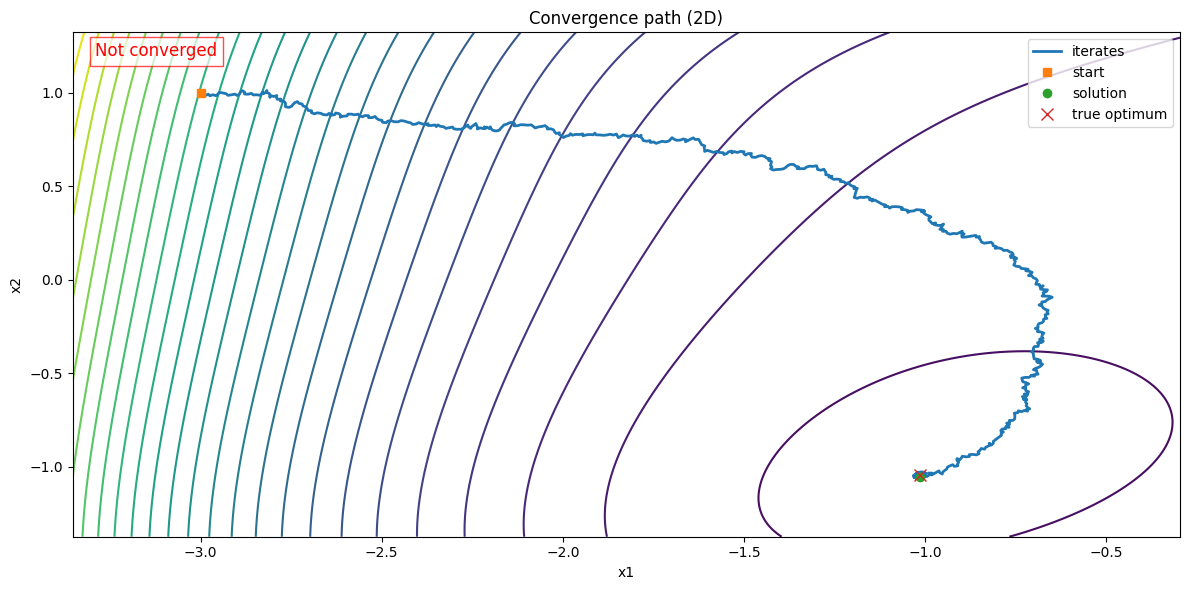

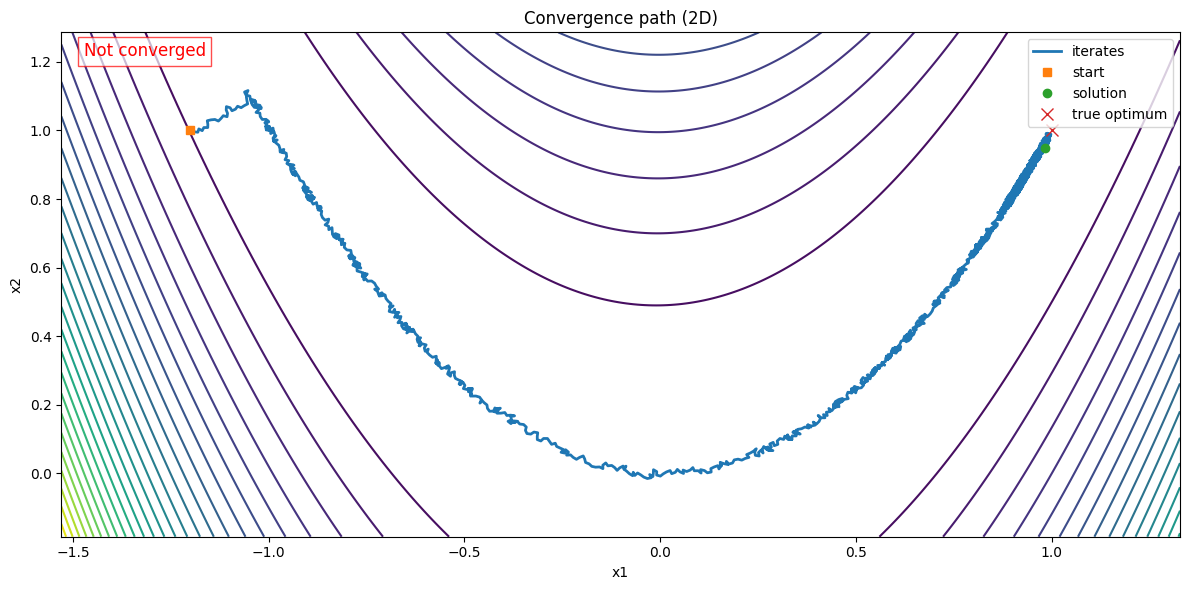

=== Resultados obtenidos (últimos 5 puntos) ===
  Iter 2996: [-0.99434803  0.98411623  0.98033226  0.96146862  0.92567579  0.85054096
  0.71970037]
  Iter 2997: [-0.99251122  0.9886345   0.9776536   0.96005055  0.92537276  0.84688602
  0.7123809 ]
  Iter 2998: [-0.99401129  0.99346539  0.98117594  0.9587848   0.92195136  0.84241169
  0.71773606]
  Iter 2999: [-0.99442518  0.99130977  0.97871482  0.96388478  0.91722608  0.84610325
  0.7125246 ]
  Iter 3000: [-0.99398482  0.98877192  0.98233153  0.95724881  0.92148269  0.84398974
  0.70882826]

Estado de convergencia: No convergió
f(x_last): 4.023468e+00

=== Óptimo conocido ===
x* = [1. 1. 1. 1. 1. 1. 1.]
f* = 0.000000e+00
Gap f(x_last) - f* = 4.023468e+00
Distancia ||x_last - x*|| = 2.023247e+00


In [1420]:
result_gradient_descent_naive = collectGradientDescentNaiveResults(
    alpha_a=0.01, alpha_b=0.01, alpha_c=0.01,
    maxIter_a=2000, maxIter_b=2500, maxIter_c=3000,
    tol_a=1e-4, tol_b=1e-4, tol_c=1e-4,
    stopCrit="grad",
    isPlottable_a=True, isPlottable_b=True, isPlottable_c=False
)
logs_naive = writeIndividualLogs(result_gradient_descent_naive, baseDir="log", prefix="gradient_descent_naive")
print("Logs generados:", logs_naive)

plotConvergencePath(
    result_gradient_descent_naive["case_a"],
    f=f_a, x_star=xstar_a, f_star=fstar_a,
    ampliturd=1,
    savePath="log/case_a_path.png"
)

plotConvergencePath(
    result_gradient_descent_naive["case_b_rosen2"],
    f=f_rosen2, x_star=xstar_b, f_star=fstar_b,
    ampliturd=1,
    savePath="log/case_b_path.png"
)

plotConvergencePath(
    result_gradient_descent_naive["case_c_rosen7"],
    f=f_rosen7, x_star=xstar_c, f_star=fstar_c
)

In [1421]:
def collectSteepestDescentResults(
    alpha_a, alpha_b, alpha_c,
    maxIter_a, maxIter_b, maxIter_c,
    tol_a, tol_b, tol_c,
    stopCrit,
    isPlottable_a, isPlottable_b, isPlottable_c
):
    """
    Ejecuta Steepest Descent (ángulo fijo 0) para tres problemas.

    Parámetros:
      - alpha_a, alpha_b, alpha_c (float): tamaño de paso por caso A/B/C.
      - maxIter_a, maxIter_b, maxIter_c (int): máx. iteraciones por caso.
      - tol_a, tol_b, tol_c (float): tolerancia de paro por caso (según stopCrit).
      - stopCrit (str): "grad" | "fx" | "xAbs" | "xRel".
      - isPlottable_a, isPlottable_b, isPlottable_c (bool): habilita registro 2D.

    Returns:
      dict con claves:
        - "case_a" | "case_b_rosen2" | "case_c_rosen7"
        - cada una contiene: {"best","xs","fxs","errors","metrics"}.
    """
    results = {}

    # Caso A
    best_a, xs_a, fxs_a, errors_a, metrics_a = steepestDescent(
        f=f_a, df=df_a, x0=x0_a,
        alpha=alpha_a, maxIter=maxIter_a, tol=tol_a, stopCrit=stopCrit,
        normOrder=2, isPlottable=isPlottable_a, randomState=SEED, verbose=False
    )
    results["case_a"] = {
        "best": best_a, "xs": xs_a, "fxs": fxs_a, "errors": errors_a, "metrics": metrics_a
    }

    # Caso B (Rosenbrock 2D)
    best_b, xs_b, fxs_b, errors_b, metrics_b = steepestDescent(
        f=f_rosen2, df=df_rosen2, x0=x0_b,
        alpha=alpha_b, maxIter=maxIter_b, tol=tol_b, stopCrit=stopCrit,
        normOrder=2, isPlottable=isPlottable_b, randomState=SEED, verbose=False
    )
    results["case_b_rosen2"] = {
        "best": best_b, "xs": xs_b, "fxs": fxs_b, "errors": errors_b, "metrics": metrics_b
    }

    # Caso C (Rosenbrock 7D)
    best_c, xs_c, fxs_c, errors_c, metrics_c = steepestDescent(
        f=f_rosen7, df=df_rosen7, x0=x0_c,
        alpha=alpha_c, maxIter=maxIter_c, tol=tol_c, stopCrit=stopCrit,
        normOrder=2, isPlottable=isPlottable_c, randomState=SEED, verbose=False
    )
    results["case_c_rosen7"] = {
        "best": best_c, "xs": xs_c, "fxs": fxs_c, "errors": errors_c, "metrics": metrics_c
    }

    return results

Logs (steepest): ['log\\steepest_descent_case_a.log', 'log\\steepest_descent_case_b_rosen2.log', 'log\\steepest_descent_case_c_rosen7.log']


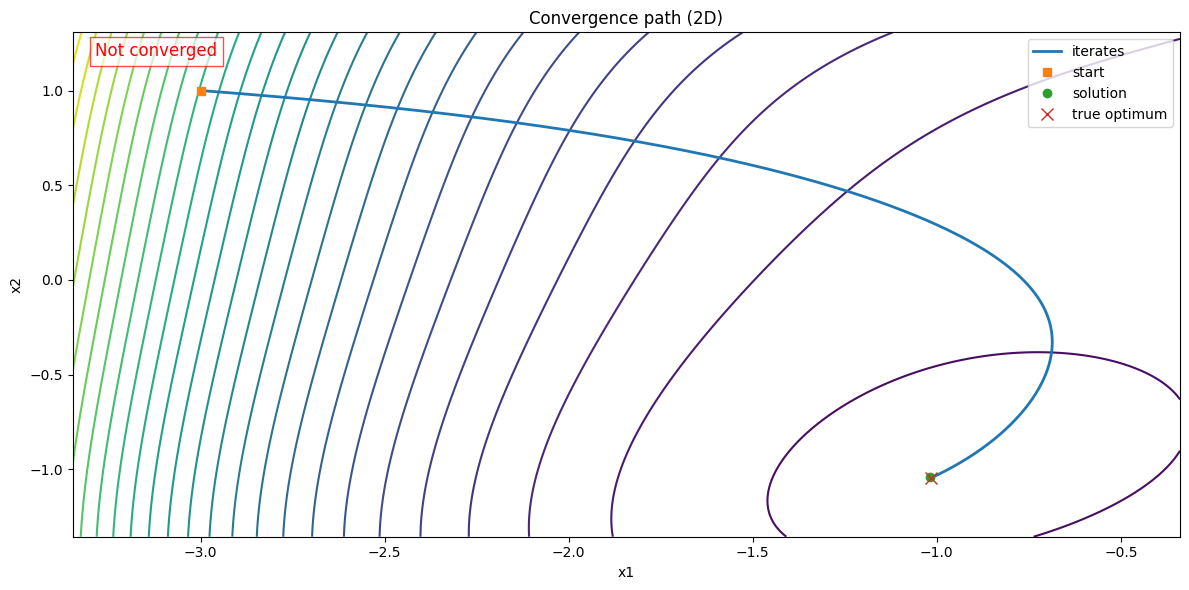

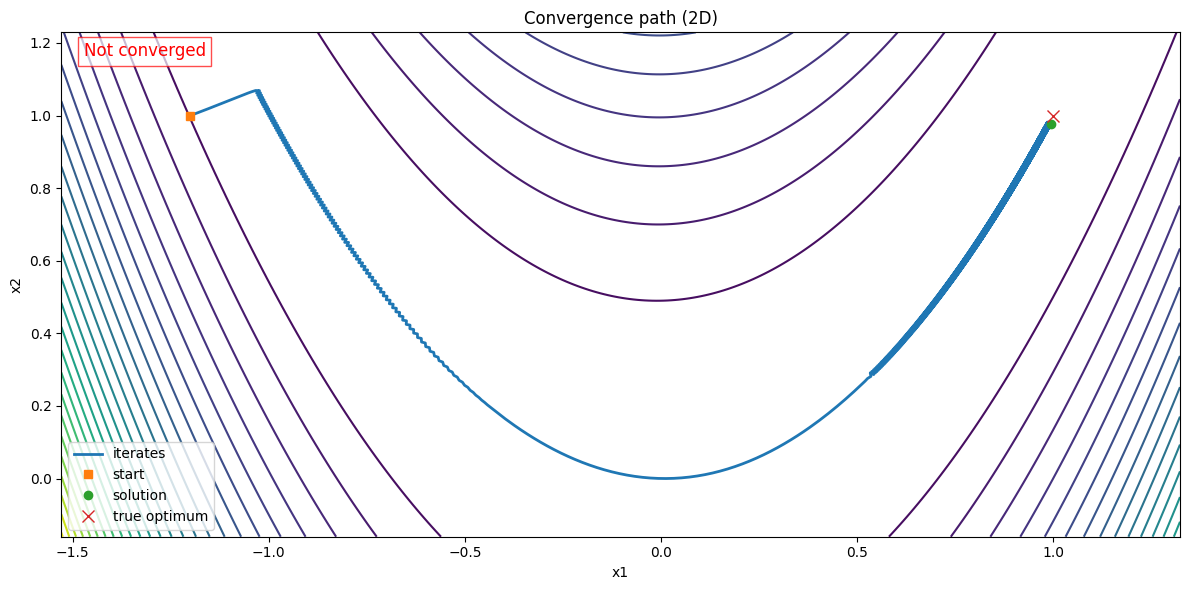

=== Resultados obtenidos (últimos 5 puntos) ===
  Iter 5996: [-0.99225985  0.99078175  0.99343909  0.9814755   0.9718038   0.93970718
  0.88553636]
  Iter 5997: [-0.99044978  0.99488333  0.98807971  0.98678496  0.96767847  0.94207773
  0.8849452 ]
  Iter 5998: [-0.99226016  0.99078245  0.99344036  0.98147807  0.97180894  0.93971702
  0.88555504]
  Iter 5999: [-0.99045013  0.99488395  0.98808104  0.98678755  0.96768351  0.94208767
  0.88496384]
  Iter 6000: [-0.99226047  0.99078315  0.99344163  0.98148064  0.97181407  0.93972685
  0.8855737 ]

Estado de convergencia: No convergió
f(x_last): 4.004779e+00

=== Óptimo conocido ===
x* = [1. 1. 1. 1. 1. 1. 1.]
f* = 0.000000e+00
Gap f(x_last) - f* = 4.004779e+00
Distancia ||x_last - x*|| = 1.996771e+00


In [1422]:
result_steepest = collectSteepestDescentResults(
    alpha_a=0.01, alpha_b=0.01, alpha_c=0.01,
    maxIter_a=5000, maxIter_b=8000, maxIter_c=6000,
    tol_a=1e-4, tol_b=1e-4, tol_c=1e-4,
    stopCrit="grad",
    isPlottable_a=True, isPlottable_b=True, isPlottable_c=False
)

logs_steep = writeIndividualLogs(result_steepest, baseDir="log", prefix="steepest_descent")
print("Logs (steepest):", logs_steep)

plotConvergencePath(
    result_steepest["case_a"],
    f=f_a, x_star=xstar_a, f_star=fstar_a,
    ampliturd=1, savePath="log/steep_case_a_path.png"
)
plotConvergencePath(
    result_steepest["case_b_rosen2"],
    f=f_rosen2, x_star=xstar_b, f_star=fstar_b,
    ampliturd=1, savePath="log/steep_case_b_path.png"
)
plotConvergencePath(
    result_steepest["case_c_rosen7"],
    f=f_rosen7, x_star=xstar_c, f_star=fstar_c
)